In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import copy
import random
from torch.nn import functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader

In [2]:
bkdatafolder = "/Volumes/T7 Touch/TheseProject/DR_KELLA/BKDataCleaned/"
dataset_name = os.listdir(bkdatafolder)

In [3]:
def createDictFloor(floor_name):
    getdict = {}
    floors = [floor for floor in dataset_name if floor_name in floor]
    for name in floors:
        floorname = name.split(".")[0]
        getdict[floorname] = pd.read_csv(bkdatafolder+name, index_col=0, parse_dates=["Date"])
        getdict[floorname] = getdict[floorname].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def createPlot(date1, date2, features, data):
    for floor in data.keys():
        data[floor].resample("5T").mean()[features][date1:date2].plot(figsize=(20,7))
        

def createDTFeat(date1, date2, datadict, features, resample_method="sum" ,scale=True):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for data in datadict.keys():
        if resample_method == "sum":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").sum()
            
        elif resample_method == "max":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").max().bfill()
        elif resample_method == "mean":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").mean().bfill()
            
        cols = resample_move[data].columns
        idx = resample_move[data].index
        
        if scale:
            scaler = MinMaxScaler()
            scaler.fit(resample_move[data])
            resample_move[data] = pd.DataFrame(scaler.transform(
                resample_move[data]),
                                               columns=cols,
                                               index=idx)
            scalers[data] = scaler

        resample_move[data]["weekday"] = resample_move[data].index.weekday
        resample_move[data]["date"] = resample_move[data].index.date
        resample_move[data]["time"] = resample_move[data].index.time
        resample_move[data]["hour"] = resample_move[data].index.hour
        resample_move[data]["minute"] = resample_move[data].index.minute

        nan = np.where(pd.isnull(resample_move[data][features]))[0]
        index_nan[data] = np.unique(resample_move[data].iloc[nan]["time"])

    return resample_move, scalers, index_nan

def getInfoTimeShape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [125]:
def rolling_window(series, window_size):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            databyDate[date][floor] = np.asarray(datadict[floor][date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def getInfoDataByDate(data, dates):
    for date in dates:
        print("Date : {}".format(date))
        for floor in data[date]:
            print("{} shape : {}".format(floor,data[date][floor].shape))
            
def LoaderByZone(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead,)
        xshape = torch.tensor(trainx, dtype=torch.float)
        yshape = torch.tensor(trainy, dtype=torch.float).squeeze(-1)
        #print(xshape.shape)
        #print(yshape.shape)
        tensorwrap = TensorDataset(xshape,yshape[:,:,0])
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

def LoaderByZoneNormal(data,zone_name,dates, lookback, lookahead, batch_size, noise=False, shuffle=False):
    firstday = data[dates[0]][zone_name]
    myX, myY = to_timeseries_input(firstday, lookback, lookahead)
    for date in dates[1:]:
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead)
        myX = np.vstack((myX, trainx))
        myY = np.vstack((myY, trainy))
    if noise :
        xshape = torch.tensor(myX, dtype=torch.float)
        xshape = xshape + torch.rand_like(xshape)
    else:
        xshape = torch.tensor(myX[:,:,0], dtype=torch.float)
    #print(myY[:,:,0].shape)
    yshape = torch.tensor(myY, dtype=torch.float).squeeze(-1)
    tensorwrap = TensorDataset(xshape, yshape)
    loaderxy = DataLoader(tensorwrap, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return loaderxy

def LoaderByZoneXY(dataX, dataY, zone_name,dates, seq_len, batch_size, shuffle=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        trainx = rolling_window(dataX[date][zone_name], seq_len)
        trainy = rolling_window(dataY[date][zone_name], seq_len)
        xshape = torch.tensor(trainx, dtype=torch.float).unsqueeze(-1)
        yshape = torch.tensor(trainy, dtype=torch.float)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

def LoaderXYtrain(dataX, dataY, zone_name, dates, seq_len, batch_size, shuffle=False, val = True):
    myX = rolling_window(dataX[dates[0]][zone_name], seq_len)
    myY = rolling_window(dataY[dates[0]][zone_name], seq_len)
    for date in dates[1:]:
        seqX = rolling_window(dataX[date][zone_name], seq_len)
        seqY = rolling_window(dataY[date][zone_name], seq_len)
        myX = np.vstack((myX, seqX))
        myY = np.vstack((myY, seqY))
    xshape = torch.tensor(myX, dtype=torch.float).unsqueeze(-1)
    yshape = torch.tensor(myY, dtype=torch.float)
    tensorwrap = TensorDataset(xshape, yshape)
    total_data = len(tensorwrap)
    if val:
        train_size = int(0.8*total_data)
        train_set, val_set = torch.utils.data.random_split(tensorwrap, [train_size, total_data - train_size],
                                                          generator=torch.Generator().manual_seed(0))
        loadertrain = DataLoader(train_set, batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderval = DataLoader(val_set, batch_size = batch_size, shuffle=shuffle, drop_last=True)
        return loadertrain, loaderval
    else :
        loaderxy = DataLoader(tensorwrap, batch_size= batch_size, shuffle=shuffle, drop_last=True)
        return loaderxy

In [126]:
date1 = "2019-03-07"
date2 = "2019-12-31"
floor_dict = createDictFloor("Floor7")
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/T7 Touch/TheseProject/DR_KELLA/BKDataCleaned/Floor7Z1.csv'

# Model

In [124]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers=1):
        super(Encoder,self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hid_dim, n_layers,batch_first=False, bias=True)
        
    def forward(self, seq, hidden=None):
        outputs, hidden = self.lstm(seq.reshape(seq.shape[1],seq.shape[0],self.input_dim))
        return outputs, hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hid_dim),
                torch.zeros(self.n_layers, batch_size, self.hid_dim))
    
class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, n_layers=1):
        super(Decoder,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        
        self.lstm = nn.LSTM(input_dim, hid_dim, n_layers, batch_first = False, bias=True)
        self.fc = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x, encoder_hidden):
        lstm_out, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden)
        output = self.fc(lstm_out.squeeze(0))
        return output, self.hidden
    
    
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, ts_out, forcing = 0.3):
        super(Seq2Seq,self).__init__()
        self.output_dim = output_dim
        self.ts_out = ts_out
        self.encoder = Encoder(input_dim, hid_dim)
        self.decoder = Decoder(input_dim,hid_dim,output_dim)
        self.forcing = forcing

        
    def forward(self, source, hidden=None, y=None):
        batch_size = source.shape[0]
        target_len = self.ts_out
        outputs = torch.zeros(target_len,batch_size,self.output_dim)
        #if hidden is not None:
        #    encoder_output, encoder_hidden = self.encoder(source, hidden)
        #else :
        encoder_hidden = self.encoder.init_hidden(batch_size)
        encoder_output, encoder_hidden = self.encoder(source)
        
        decoder_input = source[:,-1,:]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            #print(decoder_output.shape)
            outputs[t] = decoder_output
            #print(y[:,t].shape)
            if (y is not None) and (t>1) and (random.random() < self.forcing):
                #print("----Teacher Forcing----")
                decoder_input = y[:,t].unsqueeze(-1)
            else :
                #print("----Self-Generated Output")
                decoder_input = decoder_output
        return outputs.squeeze(-1).permute(1,0)
    
    
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, time_step_in, time_step_out):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.time_step_in = time_step_in
        self.time_step_out = time_step_out
        self.num_layers = 1
        
        self.encoder = nn.LSTM(self.input_size, self.output_size,
                               num_layers=self.num_layers, batch_first=True, bias=True)
        
        self.batch = nn.BatchNorm1d(self.output_size)
        self.linear2 = nn.Linear(self.num_layers*self.output_size, self.time_step_out)
        
    def forward(self,x):
        out_en, (h_en,c_en) = self.encoder(x)
        out = h_en.view(-1, self.num_layers*self.output_size)
        out = self.batch(out)
        out = nn.LeakyReLU()(out)
        #out = torch.sigmoid(self.linear(out))
        out = self.linear2(out)
        return out
    
class VanillaVAE(nn.Module):
    
    def __init__(self,input_dim, hidden_dim, latent_dim, output_length):
        super(VanillaVAE,self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.output_length = output_length
        #Encoder
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first = False, bias=True)
        self.relu = nn.LeakyReLU()
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        #Decoder
        self.decoder = nn.LSTM(latent_dim, hidden_dim, batch_first = False, bias=True)
        self.fc_decoder1 = nn.Linear(hidden_dim, latent_dim)
        self.fc_decoder2 = nn.Linear(latent_dim, input_dim)
    
        
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        
    def initHidden(self,batch_size):
        return (torch.zeros(1, batch_size, self.hidden_dim),
                torch.zeros(1, batch_size, self.hidden_dim))
        
        
    def buildEncoder(self, inputs):
        result, hidden = self.encoder(inputs.reshape(inputs.shape[1], inputs.shape[0], self.input_dim))
        #print(result.shape)
        #print(result[-1,:,:].shape)
        flatten_hid = result[-1,:,:].view(inputs.shape[0],self.hidden_dim)
        #print(flatten_hid.shape)
        mu = self.fc_mu(flatten_hid)
        log_var = self.fc_var(flatten_hid)
        
        return mu, log_var, hidden
    
    def buildDecoder(self, z, hidden):
        result, hidden = self.decoder(z.unsqueeze(0), hidden)
        #print(f"decode {hidden[0].shape}")
        latent_layer = self.fc_decoder1(result)
        output_layer = self.fc_decoder2(latent_layer)
        return latent_layer, hidden, output_layer
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps*std + mu
    '''
    def forward(self, source):
        mu, log_var = self.buildEncoder(source)
        z = self.reparameterize(mu, log_var)
        z = z.unsqueeze(1).repeat(1,self.output_length, 1)
        #print(z.shape)
        decode_out, _ = self.decoder(z)
        fc_out = self.fc_out(torch.relu(decode_out))
        return fc_out.squeeze(-1), mu, log_var'''
    
    
    def forward(self, source, y=None):
        batch_size = source.shape[0]
        mu, log_var, hidden = self.buildEncoder(source)
        decoder_hidden = hidden#self.initHidden(batch_size)
        #print(f"decode hidden {decoder_hidden[0].shape}")
        decoder_input = self.reparameterize(mu, log_var)
        #print(f"outside loop {decoder_input.shape}")
        outputs = torch.zeros(self.output_length,batch_size,self.input_dim)
        for t in range(self.output_length):
            decoder_output, hidden, final_output = self.buildDecoder(decoder_input, decoder_hidden)
            outputs[t] = final_output
            decoder_input = decoder_output.squeeze(0)
            #print(f"inside loop {decoder_input.shape}")
        return outputs.squeeze(-1).permute(1,0), mu, log_var
    
def loss_function(predict, label, mu, log_var, beta=1):
    smoothl1 = F.smooth_l1_loss(predict, label)
    kld = torch.mean(-0.5*torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1),dim=0)
    return smoothl1 + beta*kld

In [121]:
def ModelTraining(model, optimizer, loss_fn ,dataloader, validloader,scheduler,forcing = True,epochs=100, n_epochs_stop=10):
    seed_everything()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e3
    losses, mape, mae, validlosses, validmae = [], [], [], [], []
    
    for epoch in range(epochs):
        #print('Epoch {}/{}'.format(epoch, epochs - 1))
        #print('-' * 10)
        hidden = model.encoder.init_hidden(batch_size)     
        run_loss, run_mape, run_mae = 0., 0., 0.
        for data, label in dataloader:
            model.train()
            optimizer.zero_grad()
            with torch.enable_grad():
                if forcing :
                    output = model(data,label)
                    #hidden = (hidden[0].detach(), hidden[1].detach())
                else :
                    output = model(data)
                    #hidden = (hidden[0].detach(), hidden[1].detach())
                loss_val = loss_fn(output, label)
                loss_val.backward()
                optimizer.step()
                    
            run_loss += loss_val.item()*data.size(0)
            run_mape += mean_absolute_percentage_error(label.detach().numpy(),output.detach().numpy())*data.size(0)
            run_mae  += mean_absolute_error(label.detach().numpy(),output.detach().numpy())*data.size(0)
            
        epoch_loss = run_loss/len(dataloader)
        epoch_mape = run_mape/len(dataloader)
        epoch_mae = run_mae/len(dataloader)
        
        running_val = 0.
        for val, vallabel in validloader:
            model.eval()
            with torch.no_grad():
                output = model(val)
                val_loss = loss_fn(output, vallabel)
            running_val += val_loss.item()*data.size(0)
            
        epoch_val = running_val/len(validloader)
        
        validlosses.append(epoch_val)
        losses.append(epoch_loss)
        mape.append(epoch_mape)
        mae.append(epoch_mae)
        #print("Epoch: {} Loss: {} Best Loss: {} MAPE: {} MAE: {}".format(epoch, epoch_loss, best_loss, epoch_mape, epoch_mae))
                
        #validlosses.append(epoch_loss)
        #validmae.append(epoch_mae)
        
        print('[Epoch: {}]  Loss: {:.4f} ValidLoss {:.4f} MAE: {:.4f} MAPE: {:.4f}'.\
              format(epoch, epoch_loss, epoch_val, epoch_mae, epoch_mape))
        
        if epoch_val < best_loss:
            epoch_no_improve = 0
            best_loss = epoch_val
            best_model_wts = copy.deepcopy(model.state_dict())
        else :
            epoch_no_improve +=1
            if epoch_no_improve == n_epochs_stop:
                print("Early Stopping !!!")
                early_stop=True
                break
            else:
                continue
                
        if scheduler is not None:
            scheduler.step()
        
    model.load_state_dict(best_model_wts)
    
    return model, losses, validlosses,mape, mae

def ModelPrediction(model_to_test, date ,loader, lookahead):
    prediction = []
    true = []
    for val, valpred in loader[date]:
        model_to_test.eval()
        pred, _, _ = model_to_test(val)
        #print(pred.shape)
        prediction.append(pred.detach().numpy())
        true.append(valpred.detach().numpy())
    pred_array = np.asarray(prediction)
    true_array = np.asarray(true)
    pred_shape = pred_array.shape
    flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    return flattenTrue, flattenPred

def PredictionMultipleDate(model, dates, date_begin, date_end, loader, lookahead, scalers, zone_name, ft_idx):
    predictTrue = []
    predictPred = []
    valuePD = pd.DataFrame()
    idx_begin = dates.index(date_begin)
    idx_end = dates.index(date_end)
    for date in dates[idx_begin:idx_end]:
        true, pred = ModelPrediction(model, date, loader, lookahead)
        maxi = scalers[zone_name].data_max_[ft_idx]
        mini = scalers[zone_name].data_min_[ft_idx]
        true = true.reshape(-1,1)*(maxi-mini) + mini
        pred = pred.reshape(-1,1)*(maxi-mini) + mini
        array = np.concatenate([true, pred],axis=1)
        result = pd.DataFrame({"Truth": true.squeeze(),
                              "Prediction" : pred.squeeze()})
                              #"Date": pd.date_range(start=date,periods=true.shape[0], freq="5min")})
        valuePD = pd.concat((valuePD, result)).reset_index(drop=True)
    return valuePD

In [8]:
def ModelTrainingVAE(model, optimizer, loss_fn ,dataloader, validloader,scheduler,forcing = False,epochs=100, n_epochs_stop=5):
    seed_everything()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e3
    losses, mape, mae, validlosses, validmae = [], [], [], [], []
    early_stop=False
    for epoch in range(epochs):
        #print('Epoch {}/{}'.format(epoch, epochs - 1))
        #print('-' * 10)  
        run_loss, run_mape, run_mae = 0., 0., 0.
        for data, label in dataloader:
            model.train()
            optimizer.zero_grad()
            with torch.enable_grad():
                if forcing :
                    output, mu, log_var = model(data,label)
                    #hidden = (hidden[0].detach(), hidden[1].detach())
                else :
                    output, mu, log_var = model(data)
                    
                loss_val = loss_fn(output, label, mu, log_var)
                loss_val.backward()
                optimizer.step()
                    
            run_loss += loss_val.item()*data.size(0)
            run_mape += mean_absolute_percentage_error(label.detach().numpy(),output.detach().numpy())*data.size(0)
            run_mae  += mean_absolute_error(label.detach().numpy(),output.detach().numpy())*data.size(0)
            
        epoch_loss = run_loss/len(dataloader)
        epoch_mape = run_mape/len(dataloader)
        epoch_mae = run_mae/len(dataloader)
        
        running_val = 0.
        for val, vallabel in validloader:
            model.eval()
            with torch.no_grad():
                output, mu, log_var= model(val)
                val_loss = loss_fn(output,vallabel, mu, log_var)
            running_val += val_loss.item()*data.size(0)
            
        epoch_val = running_val/len(validloader)
        
        validlosses.append(epoch_val)
        losses.append(epoch_loss)
        mape.append(epoch_mape)
        mae.append(epoch_mae)
        #print("Epoch: {} Loss: {} Best Loss: {} MAPE: {} MAE: {}".format(epoch, epoch_loss, best_loss, epoch_mape, epoch_mae))
                
        #validlosses.append(epoch_loss)
        #validmae.append(epoch_mae)
        
        print('[Epoch: {}]  Loss: {:.4f} ValidLoss {:.4f} MAE: {:.4f} MAPE: {:.4f}'.\
              format(epoch, epoch_loss, epoch_val, epoch_mae, epoch_mape))
        
        if epoch_val < best_loss:
            epoch_no_improve = 0
            best_loss = epoch_val
            best_model_wts = copy.deepcopy(model.state_dict())
        else :
            epoch_no_improve +=1
            if epoch_no_improve == n_epochs_stop:
                print("Early Stopping !!!")
                #early_stop=True
                break
            else:
                continue
                
        
        if scheduler is not None:
            scheduler.step()
        
    model.load_state_dict(best_model_wts)
    
    return model, losses, validlosses,mape, mae

# Parameters

In [116]:
myfloor = "Floor7Z1"
lookback = 13
lookahead = 5
batch_size = 16

# Temperature

In [10]:
featureX = ["temperature"]
resampleX_method = "max"
resampleX, scalersX, index_nan = createDTFeat(date1, date2, floor_dict, featureX,resample_method=resampleX_method)
cleanedDataX, remain_date = cleanNan(resampleX, index_nan)

In [11]:
cutting_date = "2019-08-08"
cutting_date2 = "2019-09-09"
train_date, test_date = splitDate(remain_date, cutting_date)
valid_date, test_date = splitDate(test_date, cutting_date2)
databyDateX = createDataByDate(cleanedDataX, featureX, remain_date)

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_947/241493879.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [62]:
#loaderZtrain, loaderZval = LoaderXYtrain(databyDateX, databyDateY,myfloor,train_date, seq_len, batch_size, shuffle=False, val=False)
loaderZtrain =LoaderByZoneNormal(databyDateX, myfloor, train_date, lookback, lookahead, batch_size,noise=False, shuffle=False)
loaderZvalid = LoaderByZoneNormal(databyDateX, myfloor, valid_date, lookback, lookahead, batch_size, shuffle=False)
loaderZtest = LoaderByZone(databyDateX, myfloor, test_date, lookback, lookahead, batch_size)

In [117]:
len(loaderZvalid.dataset), len(loaderZtrain.dataset)

(8672, 42005)

In [122]:
loss_fn = nn.SmoothL1Loss()
#modelTemp = Seq2Seq(input_dim=1, hid_dim=30, output_dim=1, ts_out=lookahead)
modelTemp = VanillaVAE(1, 100, 5, lookahead)
optimizerTemp = optim.Adam(modelTemp.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizerTemp,gamma=0.9)

In [123]:
#trainedTemp, losses, validlosses,mape,mae = ModelTraining(modelTemp, optimizerTemp, loss_fn, 
#                                                          loaderZtrain, loaderZvalid,None,epochs=50, n_epochs_stop=20)
trainedTemp, losses, validlosses,mape,mae = ModelTrainingVAE(modelTemp, optimizerTemp, loss_function, 
                                                             loaderZtrain, loaderZvalid, None,
                                                             epochs=100,
                                                             n_epochs_stop=10)

[Epoch: 0]  Loss: 0.3531 ValidLoss 0.2939 MAE: 2.8344 MAPE: 11.1742
[Epoch: 1]  Loss: 0.3470 ValidLoss 0.2964 MAE: 2.8176 MAPE: 11.2919
[Epoch: 2]  Loss: 0.3707 ValidLoss 0.2871 MAE: 2.9079 MAPE: 11.6902
[Epoch: 3]  Loss: 0.3448 ValidLoss 0.2970 MAE: 2.8012 MAPE: 11.2311
[Epoch: 4]  Loss: 0.3739 ValidLoss 0.2965 MAE: 2.9106 MAPE: 11.7140
[Epoch: 5]  Loss: 0.3499 ValidLoss 0.2954 MAE: 2.8247 MAPE: 11.2680
[Epoch: 6]  Loss: 0.3640 ValidLoss 0.2915 MAE: 2.8755 MAPE: 11.5245


KeyboardInterrupt: 

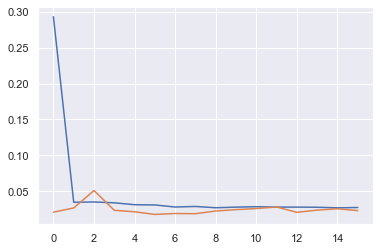

In [108]:
plt.plot(losses)
plt.plot(validlosses)

In [109]:
ft_idx = 3
may = [date for date in test_date if '2019-09' in date]
resultpd = PredictionMultipleDate(trainedTemp,test_date,may[0], may[5],loaderZtest,lookahead, scalersX, myfloor, ft_idx)

<AxesSubplot:>

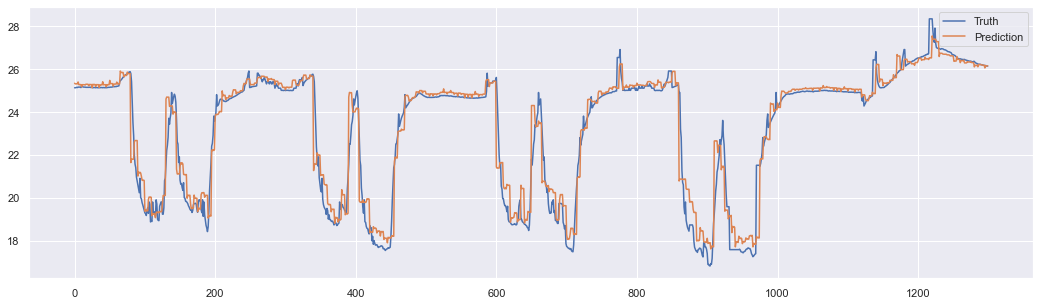

In [110]:
resultpd[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))

In [21]:
lastx,lasty = loaderZtrain.dataset[-16:]

In [22]:
lastx.shape

torch.Size([16, 13, 1])

In [32]:
def Prediction(model,sample):
    model.eval()
    with torch.no_grad():
        pred,_,_ = model(sample)
    return pred

def PredictToPredict(model, sample,nb_pred):
    init=sample
    for t in range(1,nb_pred+1):
        series = Prediction(model, sample)
        init = torch.cat((init, series.unsqueeze(-1)), dim=1)
        sample = init[:,-lookback:,:]
    return init

In [111]:
idx_date = 0
it = iter(loaderZtest[test_date[idx_date]])
x,y = next(it)

In [112]:
test = PredictToPredict(trainedTemp,x,240)

<AxesSubplot:>

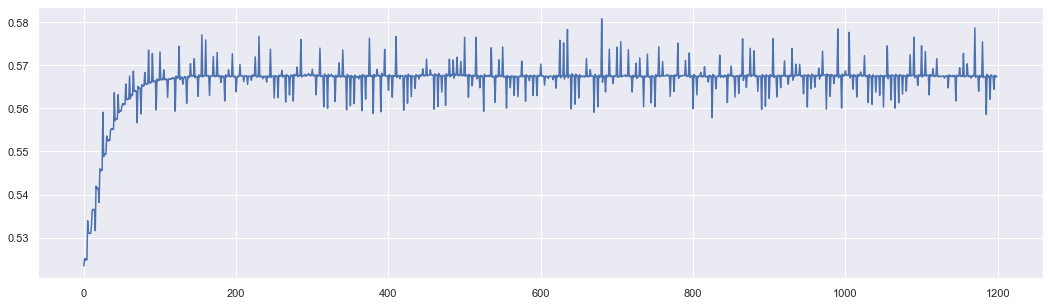

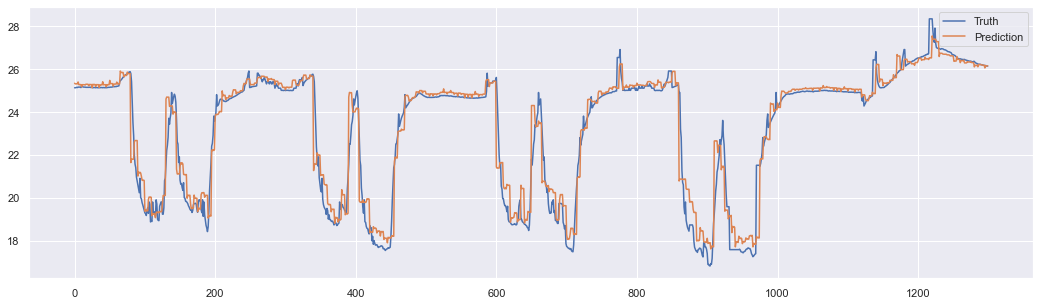

In [113]:
plt.figure(figsize=(18,5))
plt.plot(test[-1,lookback:,:].detach().numpy().squeeze())
resultpd[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))

In [1391]:
true, pred = ModelPrediction(trainedTemp,test_date[idx_date], loaderZtest, lookahead)

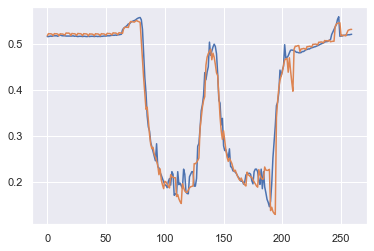

In [1392]:
plt.plot(true)
plt.plot(pred)

In [549]:
def RollingPrediction(model, samplex, trueloader ,nb_pred, window=1):
    pred = PredictToPredict(model, samplex,1)
    datapred = pd.DataFrame({"Prediction":pred.detach().numpy().squeeze()})
    lookback = samplex.size(1)
    for i in range(nb_pred):
        rolling = datapred.rolling(window=window)
        rolling_mean = rolling.mean()
        x = torch.tensor(rolling_mean[-lookback:].values, dtype=torch.float).reshape(1,-1,1)
        nextpred = pd.DataFrame({"Prediction":model(x).squeeze().detach().numpy()})
        datapred = pd.concat([datapred, nextpred],axis=0).reset_index(drop=True)
    maxi = scalersX[myfloor].data_max_[ft_idx]
    mini = scalersX[myfloor].data_min_[ft_idx]
    datapred["Prediction"] = datapred["Prediction"]*(maxi-mini) + mini
    return datapred